# Method 8 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

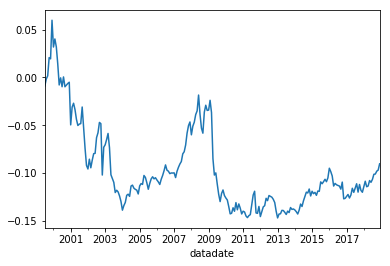

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.059924
2000-12-31   -0.061277
2001-12-31   -0.087580
2002-12-31    0.020956
2003-12-31   -0.061324
2004-12-31    0.009091
2005-12-31    0.019382
2006-12-31    0.005478
2007-12-31    0.059472
2008-12-31    0.012660
2009-12-31   -0.092331
2010-12-31   -0.022021
2011-12-31    0.009172
2012-12-31   -0.005863
2013-12-31    0.002842
2014-12-31    0.015793
2015-12-31    0.021640
2016-12-31   -0.024014
2017-12-31    0.007339
2018-12-31    0.033866
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     45.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.69e-28
Time:                        06:46:44   Log-Likelihood:                 798.66
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1570.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.936      0.350      -0.002       0.001
mktrf         -0.0275      0.015     -1.828      0.069      -0.057       0.002
me            -0.0273      0.017     -1.561      0.120      -0.062       0.007
ia            -0.1730      0.027     -6.511      0.000      -0.225      -0.121
roe            0.2009      0.023      8.833      0.000       0.156       0.246
==============================================================================
Omnibus:                       47.648   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.931
Skew:                          -0.348   Prob(JB):                    1.84e-106
Kurtosis:                      10.033   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     18.26
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.93e-13
Time:                        06:46:44   Log-Likelihood:                 798.66
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1570.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.869      0.385      -0.002       0.001
mktrf         -0.0275      0.017     -1.586      0.113      -0.061       0.006
me            -0.0273      0.040     -0.685      0.493      -0.105       0.051
ia            -0.1730      0.069     -2.515      0.012      -0.308      -0.038
roe            0.2009      0.041      4.952      0.000       0.121       0.280
==============================================================================
Omnibus:                       47.648   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.931
Skew:                          -0.348   Prob(JB):                    1.84e-106
Kurtosis:                      10.033   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     19.05
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.54e-13
Time:                        06:46:44   Log-Likelihood:                 798.66
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1570.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.775      0.438      -0.002       0.001
mktrf         -0.0275      0.016     -1.685      0.092      -0.059       0.004
me            -0.0273      0.043     -0.634      0.526      -0.112       0.057
ia            -0.1730      0.062     -2.776      0.006      -0.295      -0.051
roe            0.2009      0.042      4.803      0.000       0.119       0.283
==============================================================================
Omnibus:                       47.648   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.931
Skew:                          -0.348   Prob(JB):                    1.84e-106
Kurtosis:                      10.033   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     21.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-17
Time:                        06:46:44   Log-Likelihood:                 775.55
No. Observations:                 234   AIC:                            -1539.
Df Residuals:                     228   BIC:                            -1518.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.65e-05      0.001      0.124      0.901      -0.001       0.001
mktrf         -0.0620      0.017     -3.724      0.000      -0.095      -0.029
smb           -0.0596      0.022     -2.710      0.007      -0.103      -0.016
hml           -0.0987      0.026     -3.807      0.000      -0.150      -0.048
rmw            0.0948      0.029      3.235      0.001       0.037       0.153
cma           -0.0547      0.037     -1.468      0.143      -0.128       0.019
==============================================================================
Omnibus:                       70.459   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.389
Skew:                          -0.861   Prob(JB):                    2.93e-143
Kurtosis:                      11.022   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     27.95
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.79e-22
Time:                        06:46:44   Log-Likelihood:                 775.55
No. Observations:                 234   AIC:                            -1539.
Df Residuals:                     228   BIC:                            -1518.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.65e-05      0.001      0.126      0.900      -0.001       0.001
mktrf         -0.0620      0.015     -4.032      0.000      -0.092      -0.032
smb           -0.0596      0.040     -1.499      0.134      -0.137       0.018
hml           -0.0987      0.036     -2.709      0.007      -0.170      -0.027
rmw            0.0948      0.051      1.841      0.066      -0.006       0.196
cma           -0.0547      0.093     -0.590      0.555      -0.236       0.127
==============================================================================
Omnibus:                       70.459   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.389
Skew:                          -0.861   Prob(JB):                    2.93e-143
Kurtosis:                      11.022   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     41.66
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.32e-30
Time:                        06:46:44   Log-Likelihood:                 775.55
No. Observations:                 234   AIC:                            -1539.
Df Residuals:                     228   BIC:                            -1518.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.65e-05      0.001      0.112      0.911      -0.001       0.001
mktrf         -0.0620      0.014     -4.454      0.000      -0.089      -0.035
smb           -0.0596      0.037     -1.589      0.112      -0.133       0.014
hml           -0.0987      0.037     -2.702      0.007      -0.170      -0.027
rmw            0.0948      0.054      1.747      0.081      -0.012       0.201
cma           -0.0547      0.096     -0.571      0.568      -0.242       0.133
==============================================================================
Omnibus:                       70.459   Durbin-Watson:                   2.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.389
Skew:                          -0.861   Prob(JB):                    2.93e-143
Kurtosis:                      11.022   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     144.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.80e-61
Time:                        06:46:44   Log-Likelihood:                 877.96
No. Observations:                 234   AIC:                            -1746.
Df Residuals:                     229   BIC:                            -1729.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.328      0.185      -0.001       0.000
mktrf         -0.0040      0.010     -0.408      0.684      -0.023       0.015
smb           -0.1426      0.012    -11.587      0.000      -0.167      -0.118
hml           -0.0713      0.012     -5.835      0.000      -0.095      -0.047
umd            0.1513      0.008     18.861      0.000       0.135       0.167
==============================================================================
Omnibus:                       38.568   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.801
Skew:                          -0.441   Prob(JB):                     2.77e-46
Kurtosis:                       7.554   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     48.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.63e-29
Time:                        06:46:44   Log-Likelihood:                 877.96
No. Observations:                 234   AIC:                            -1746.
Df Residuals:                     229   BIC:                            -1729.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.202      0.229      -0.001       0.000
mktrf         -0.0040      0.014     -0.288      0.773      -0.031       0.023
smb           -0.1426      0.015     -9.775      0.000      -0.171      -0.114
hml           -0.0713      0.015     -4.830      0.000      -0.100      -0.042
umd            0.1513      0.017      8.719      0.000       0.117       0.185
==============================================================================
Omnibus:                       38.568   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.801
Skew:                          -0.441   Prob(JB):                     2.77e-46
Kurtosis:                       7.554   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     42.83
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.42e-27
Time:                        06:46:44   Log-Likelihood:                 877.96
No. Observations:                 234   AIC:                            -1746.
Df Residuals:                     229   BIC:                            -1729.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.071      0.284      -0.001       0.000
mktrf         -0.0040      0.015     -0.265      0.791      -0.034       0.026
smb           -0.1426      0.014    -10.051      0.000      -0.170      -0.115
hml           -0.0713      0.015     -4.789      0.000      -0.101      -0.042
umd            0.1513      0.019      8.016      0.000       0.114       0.188
==============================================================================
Omnibus:                       38.568   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.801
Skew:                          -0.441   Prob(JB):                     2.77e-46
Kurtosis:                       7.554   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     26.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.11e-15
Time:                        06:46:44   Log-Likelihood:                 385.55
No. Observations:                 120   AIC:                            -761.1
Df Residuals:                     115   BIC:                            -747.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.645      0.103      -0.003       0.000
mktrf         -0.0052      0.026     -0.203      0.839      -0.056       0.046
me             0.0155      0.025      0.610      0.543      -0.035       0.066
ia            -0.2085      0.040     -5.258      0.000      -0.287      -0.130
roe            0.2643      0.035      7.532      0.000       0.195       0.334
==============================================================================
Omnibus:                       17.601   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.008
Skew:                           0.008   Prob(JB):                     2.57e-18
Kurtosis:                       7.025   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     24.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-14
Time:                        06:46:44   Log-Likelihood:                 385.55
No. Observations:                 120   AIC:                            -761.1
Df Residuals:                     115   BIC:                            -747.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.509      0.131      -0.004       0.000
mktrf         -0.0052      0.023     -0.230      0.818      -0.050       0.039
me             0.0155      0.045      0.347      0.729      -0.072       0.103
ia            -0.2085      0.084     -2.496      0.013      -0.372      -0.045
roe            0.2643      0.039      6.763      0.000       0.188       0.341
==============================================================================
Omnibus:                       17.601   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.008
Skew:                           0.008   Prob(JB):                     2.57e-18
Kurtosis:                       7.025   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     26.04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.24e-15
Time:                        06:46:44   Log-Likelihood:                 385.55
No. Observations:                 120   AIC:                            -761.1
Df Residuals:                     115   BIC:                            -747.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.373      0.170      -0.004       0.001
mktrf         -0.0052      0.021     -0.245      0.807      -0.047       0.037
me             0.0155      0.049      0.317      0.751      -0.080       0.111
ia            -0.2085      0.077     -2.706      0.007      -0.359      -0.058
roe            0.2643      0.037      7.204      0.000       0.192       0.336
==============================================================================
Omnibus:                       17.601   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.008
Skew:                           0.008   Prob(JB):                     2.57e-18
Kurtosis:                       7.025   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     8.898
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.70e-07
Time:                        06:46:44   Log-Likelihood:                 366.57
No. Observations:                 120   AIC:                            -721.1
Df Residuals:                     114   BIC:                            -704.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.741      0.460      -0.003       0.001
mktrf         -0.0700      0.032     -2.201      0.030      -0.133      -0.007
smb           -0.0238      0.036     -0.660      0.510      -0.095       0.048
hml           -0.1235      0.044     -2.797      0.006      -0.211      -0.036
rmw            0.1301      0.052      2.500      0.014       0.027       0.233
cma           -0.0580      0.057     -1.017      0.311      -0.171       0.055
==============================================================================
Omnibus:                       25.534   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.349
Skew:                          -0.633   Prob(JB):                     1.46e-20
Kurtosis:                       7.083   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     11.74
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.63e-09
Time:                        06:46:44   Log-Likelihood:                 366.57
No. Observations:                 120   AIC:                            -721.1
Df Residuals:                     114   BIC:                            -704.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.718      0.473      -0.003       0.001
mktrf         -0.0700      0.030     -2.360      0.018      -0.128      -0.012
smb           -0.0238      0.053     -0.448      0.654      -0.128       0.080
hml           -0.1235      0.049     -2.523      0.012      -0.219      -0.028
rmw            0.1301      0.063      2.057      0.040       0.006       0.254
cma           -0.0580      0.114     -0.511      0.609      -0.281       0.165
==============================================================================
Omnibus:                       25.534   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.349
Skew:                          -0.633   Prob(JB):                     1.46e-20
Kurtosis:                       7.083   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     19.97
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.95e-14
Time:                        06:46:44   Log-Likelihood:                 366.57
No. Observations:                 120   AIC:                            -721.1
Df Residuals:                     114   BIC:                            -704.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.636      0.525      -0.003       0.002
mktrf         -0.0700      0.029     -2.438      0.015      -0.126      -0.014
smb           -0.0238      0.048     -0.500      0.617      -0.117       0.069
hml           -0.1235      0.046     -2.680      0.007      -0.214      -0.033
rmw            0.1301      0.062      2.095      0.036       0.008       0.252
cma           -0.0580      0.117     -0.498      0.619      -0.286       0.170
==============================================================================
Omnibus:                       25.534   Durbin-Watson:                   2.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.349
Skew:                          -0.633   Prob(JB):                     1.46e-20
Kurtosis:                       7.083   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     92.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.31e-35
Time:                        06:46:44   Log-Likelihood:                 433.12
No. Observations:                 120   AIC:                            -856.2
Df Residuals:                     115   BIC:                            -842.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.238      0.218      -0.002       0.000
mktrf          0.0134      0.015      0.883      0.379      -0.017       0.044
smb           -0.1508      0.017     -8.718      0.000      -0.185      -0.117
hml           -0.0792      0.017     -4.568      0.000      -0.113      -0.045
umd            0.1723      0.011     16.128      0.000       0.151       0.193
==============================================================================
Omnibus:                       13.824   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.498
Skew:                          -0.295   Prob(JB):                     1.19e-08
Kurtosis:                       5.637   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     33.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-18
Time:                        06:46:44   Log-Likelihood:                 433.12
No. Observations:                 120   AIC:                            -856.2
Df Residuals:                     115   BIC:                            -842.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.122      0.262      -0.002       0.001
mktrf          0.0134      0.017      0.803      0.422      -0.019       0.046
smb           -0.1508      0.017     -8.902      0.000      -0.184      -0.118
hml           -0.0792      0.017     -4.674      0.000      -0.112      -0.046
umd            0.1723      0.019      9.246      0.000       0.136       0.209
==============================================================================
Omnibus:                       13.824   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.498
Skew:                          -0.295   Prob(JB):                     1.19e-08
Kurtosis:                       5.637   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     39.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.93e-21
Time:                        06:46:44   Log-Likelihood:                 433.12
No. Observations:                 120   AIC:                            -856.2
Df Residuals:                     115   BIC:                            -842.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.012      0.311      -0.002       0.001
mktrf          0.0134      0.017      0.771      0.441      -0.021       0.048
smb           -0.1508      0.018     -8.472      0.000      -0.186      -0.116
hml           -0.0792      0.018     -4.308      0.000      -0.115      -0.043
umd            0.1723      0.019      9.131      0.000       0.135       0.209
==============================================================================
Omnibus:                       13.824   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.498
Skew:                          -0.295   Prob(JB):                     1.19e-08
Kurtosis:                       5.637   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     41.75
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.49e-21
Time:                        06:46:44   Log-Likelihood:                 464.74
No. Observations:                 114   AIC:                            -919.5
Df Residuals:                     109   BIC:                            -905.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.998      0.320      -0.000       0.001
mktrf         -0.0303      0.012     -2.455      0.016      -0.055      -0.006
me            -0.1362      0.019     -7.147      0.000      -0.174      -0.098
ia            -0.1040      0.026     -3.933      0.000      -0.156      -0.052
roe            0.0768      0.023      3.307      0.001       0.031       0.123
==============================================================================
Omnibus:                       14.673   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.998
Skew:                          -0.293   Prob(JB):                     4.60e-10
Kurtosis:                       5.951   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     55.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.66e-25
Time:                        06:46:44   Log-Likelihood:                 464.74
No. Observations:                 114   AIC:                            -919.5
Df Residuals:                     109   BIC:                            -905.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.259      0.208      -0.000       0.001
mktrf         -0.0303      0.014     -2.144      0.032      -0.058      -0.003
me            -0.1362      0.021     -6.386      0.000      -0.178      -0.094
ia            -0.1040      0.031     -3.304      0.001      -0.166      -0.042
roe            0.0768      0.025      3.041      0.002       0.027       0.126
==============================================================================
Omnibus:                       14.673   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.998
Skew:                          -0.293   Prob(JB):                     4.60e-10
Kurtosis:                       5.951   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     74.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.80e-30
Time:                        06:46:44   Log-Likelihood:                 464.74
No. Observations:                 114   AIC:                            -919.5
Df Residuals:                     109   BIC:                            -905.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.294      0.196      -0.000       0.001
mktrf         -0.0303      0.013     -2.245      0.025      -0.057      -0.004
me            -0.1362      0.022     -6.281      0.000      -0.179      -0.094
ia            -0.1040      0.035     -2.932      0.003      -0.173      -0.034
roe            0.0768      0.024      3.213      0.001       0.030       0.124
==============================================================================
Omnibus:                       14.673   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.998
Skew:                          -0.293   Prob(JB):                     4.60e-10
Kurtosis:                       5.951   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     38.01
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.49e-22
Time:                        06:46:44   Log-Likelihood:                 469.65
No. Observations:                 114   AIC:                            -927.3
Df Residuals:                     108   BIC:                            -910.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.320      0.190      -0.000       0.001
mktrf         -0.0351      0.011     -3.100      0.002      -0.058      -0.013
smb           -0.1373      0.018     -7.466      0.000      -0.174      -0.101
hml           -0.0486      0.023     -2.073      0.041      -0.095      -0.002
rmw            0.0468      0.029      1.628      0.106      -0.010       0.104
cma           -0.0828      0.036     -2.271      0.025      -0.155      -0.011
==============================================================================
Omnibus:                       15.510   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.305
Skew:                          -0.428   Prob(JB):                     4.81e-09
Kurtosis:                       5.708   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     157.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.27e-48
Time:                        06:46:44   Log-Likelihood:                 469.65
No. Observations:                 114   AIC:                            -927.3
Df Residuals:                     108   BIC:                            -910.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.113      0.035    3.86e-05       0.001
mktrf         -0.0351      0.012     -2.901      0.004      -0.059      -0.011
smb           -0.1373      0.015     -9.199      0.000      -0.167      -0.108
hml           -0.0486      0.021     -2.304      0.021      -0.090      -0.007
rmw            0.0468      0.026      1.766      0.077      -0.005       0.099
cma           -0.0828      0.041     -2.043      0.041      -0.162      -0.003
==============================================================================
Omnibus:                       15.510   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.305
Skew:                          -0.428   Prob(JB):                     4.81e-09
Kurtosis:                       5.708   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     281.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.44e-60
Time:                        06:46:44   Log-Likelihood:                 469.65
No. Observations:                 114   AIC:                            -927.3
Df Residuals:                     108   BIC:                            -910.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.317      0.021    8.21e-05       0.001
mktrf         -0.0351      0.012     -2.979      0.003      -0.058      -0.012
smb           -0.1373      0.015     -8.996      0.000      -0.167      -0.107
hml           -0.0486      0.020     -2.437      0.015      -0.088      -0.010
rmw            0.0468      0.024      1.921      0.055      -0.001       0.094
cma           -0.0828      0.044     -1.864      0.062      -0.170       0.004
==============================================================================
Omnibus:                       15.510   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.305
Skew:                          -0.428   Prob(JB):                     4.81e-09
Kurtosis:                       5.708   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     63.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.49e-27
Time:                        06:46:44   Log-Likelihood:                 480.22
No. Observations:                 114   AIC:                            -950.4
Df Residuals:                     109   BIC:                            -936.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.664      0.508      -0.000       0.001
mktrf         -0.0273      0.010     -2.672      0.009      -0.048      -0.007
smb           -0.1524      0.016     -9.569      0.000      -0.184      -0.121
hml           -0.0681      0.016     -4.155      0.000      -0.101      -0.036
umd            0.0707      0.012      5.714      0.000       0.046       0.095
==============================================================================
Omnibus:                        7.854   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               12.768
Skew:                          -0.238   Prob(JB):                      0.00169
Kurtosis:                       4.569   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     104.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.53e-36
Time:                        06:46:44   Log-Likelihood:                 480.22
No. Observations:                 114   AIC:                            -950.4
Df Residuals:                     109   BIC:                            -936.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.263      0.207      -0.000       0.001
mktrf         -0.0273      0.009     -2.888      0.004      -0.046      -0.009
smb           -0.1524      0.018     -8.565      0.000      -0.187      -0.117
hml           -0.0681      0.014     -4.748      0.000      -0.096      -0.040
umd            0.0707      0.014      5.011      0.000       0.043       0.098
==============================================================================
Omnibus:                        7.854   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               12.768
Skew:                          -0.238   Prob(JB):                      0.00169
Kurtosis:                       4.569   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     90.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-33
Time:                        06:46:44   Log-Likelihood:                 480.22
No. Observations:                 114   AIC:                            -950.4
Df Residuals:                     109   BIC:                            -936.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.636      0.102   -4.79e-05       0.001
mktrf         -0.0273      0.009     -2.986      0.003      -0.045      -0.009
smb           -0.1524      0.019     -7.981      0.000      -0.190      -0.115
hml           -0.0681      0.014     -4.906      0.000      -0.095      -0.041
umd            0.0707      0.015      4.589      0.000       0.040       0.101
==============================================================================
Omnibus:                        7.854   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               12.768
Skew:                          -0.238   Prob(JB):                      0.00169
Kurtosis:                       4.569   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""